In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from collections import Counter
from sklearn.metrics import roc_curve, auc, average_precision_score
import seaborn as sns

In [2]:
#load the data set
path = 'steam-200k.csv'

#create dataFrame
df = pd.read_csv(path, header = None,
                 names = ['UserID', 'Game', 'Action', 'Hours', 'No used'])
df.head()

,UserID,Game,Action,Hours,No used
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [3]:
df['Played Time'] = df['Hours'].astype('float32')

df.loc[(df['Action'] == 'purchase') & (df['Hours'] == 1.0), 'Played Time'] = 0

df.UserID = df.UserID.astype('int')
df = df.sort_values(['UserID', 'Game', 'Played Time'])

#drop the no used column
clean_df = df.drop_duplicates(['UserID', 'Game'], keep = 'last').drop(['Action', 'Hours', 'No used'], axis = 1)

clean_df.head()

,UserID,Game,Played Time
65430,5250,Alien Swarm,4.9
65424,5250,Cities Skylines,144.0
65435,5250,Counter-Strike,0.0
65436,5250,Counter-Strike Source,0.0
65437,5250,Day of Defeat,0.0


In [4]:
purchase_ratings = df[df.Action == "purchase"].groupby(["UserID","Game"])["Hours"].count()
purchase_ratings.describe()

count    128804.000000
mean          1.005489
std           0.073884
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: Hours, dtype: float64

In [5]:
purchase_ratings[purchase_ratings > 1][:5] #user who bought the same game two times

UserID   Game                                        
561758   Sid Meier's Civilization IV                     2
         Sid Meier's Civilization IV Beyond the Sword    2
         Sid Meier's Civilization IV Colonization        2
         Sid Meier's Civilization IV Warlords            2
1936551  Sid Meier's Civilization IV Colonization        2
Name: Hours, dtype: int64

In [6]:
purchase_ratings[purchase_ratings > 1].shape

(707,)

In [7]:
#make the purchase of game as rating of 1
purchase_ratings[purchase_ratings > 1] = 1

In [8]:
games_played = df[df.Action == "play"].groupby(["UserID","Game"])["Hours"].sum()
games_played_per_user = df[df.Action =="play"].groupby(["UserID"])["Game"].nunique()

average_games_played = games_played_per_user.mean()
weighted_games_played = games_played * (average_games_played / games_played_per_user)

print (games_played_per_user.describe())
print ()
print (games_played_per_user[games_played_per_user == 498][:])
print ()
print (games_played_per_user[games_played_per_user == 1][:5])
print ()
print (games_played_per_user[games_played_per_user > average_games_played][:1])

count    11350.000000
mean         6.209427
std         17.754906
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        498.000000
Name: Game, dtype: float64

UserID
62990992    498
Name: Game, dtype: int64

UserID
144736    1
381543    1
577614    1
635733    1
976129    1
Name: Game, dtype: int64

UserID
76767    20
Name: Game, dtype: int64


In [9]:
#function to define the ratings
def to_explicit_ratings(series):
    games = series.index.levels[1].tolist()
    hours_ratings = series.copy()
    for game_played in games:
        sliced_data = hours_ratings.xs(game_played, level=1)
        descr = sliced_data.describe()
        a = sliced_data[sliced_data >= descr["75%"]].index.tolist()
        hours_ratings.loc[(a, game_played)] = 5
        b = sliced_data[(sliced_data >= descr["50%"]) & (sliced_data < descr["75%"])].index.tolist()
        hours_ratings.loc[(b, game_played)] = 4
        c = sliced_data[(sliced_data >= descr["25%"]) & (sliced_data < descr["50%"])].index.tolist()
        hours_ratings.loc[(c, game_played)] = 3
        d = sliced_data[sliced_data < descr["25%"]].index.tolist()
        hours_ratings.loc[(d, game_played)] = 2
    
    return hours_ratings

In [10]:
hours_ratings = to_explicit_ratings(weighted_games_played)

(128804,)
count    128804.000000
mean          2.389266
std           1.519901
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
dtype: float64


NameError: name 'plt' is not defined

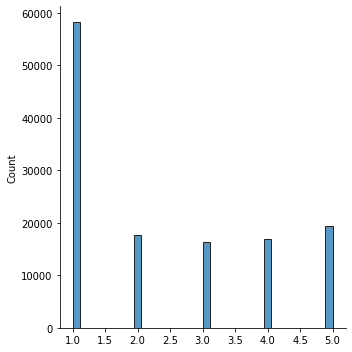

In [11]:
mean_weighted_ratings = purchase_ratings.combine(hours_ratings, max)
print (mean_weighted_ratings.shape)
print (mean_weighted_ratings.describe())

sns.displot(mean_weighted_ratings, kde=False)
plt.show()

In [12]:
#display change before apply weight and after apply weight
def display_before_and_after(user_id, before, after):
    print ("====Before====")
    games_played = min(len(non_weighted_ratings.loc[user_id]), 10)
    idx = before.xs(user_id, level=0).sample(games_played).index.tolist()
    print (before.xs(user_id, level=0)[idx])
    print ("====After====")
    print (after.xs(user_id, level=0)[idx])

In [13]:
non_weighted_ratings = to_explicit_ratings(games_played)
non_weighted_ratings = purchase_ratings.combine(non_weighted_ratings, max)
display_before_and_after(62990992, non_weighted_ratings, mean_weighted_ratings)

====Before====
Game
Sid Meier's Civilization V    5.0
Pid                           1.0
Trine 2                       3.0
Monaco                        5.0
XCOM Enemy Within             1.0
99 Levels To Hell             5.0
Shadow Warrior                3.0
Hitman Sniper Challenge       3.0
Speed Kills                   5.0
Rise of Venice                3.0
Name: Hours, dtype: float64
====After====
Game
Sid Meier's Civilization V    3.0
Pid                           1.0
Trine 2                       2.0
Monaco                        3.0
XCOM Enemy Within             1.0
99 Levels To Hell             4.0
Shadow Warrior                2.0
Hitman Sniper Challenge       2.0
Speed Kills                   5.0
Rise of Venice                2.0
dtype: float64


In [14]:
display_before_and_after(309167186, non_weighted_ratings, mean_weighted_ratings)

====Before====
Game
Portal 2    2.0
Name: Hours, dtype: float64
====After====
Game
Portal 2    5.0
dtype: float64


In [15]:
# cleanup
purchase_ratings = None
hours_ratings = None

In [16]:
ratings = mean_weighted_ratings.reset_index()
ratings.rename(columns={0:"Rating"}, inplace=True)

In [17]:
ratings[ratings.UserID == 309167186]

,UserID,Game,Rating
128777,309167186,Portal 2,5.0


In [18]:
df2 = ratings
df2.head()

,UserID,Game,Rating
0,5250,Alien Swarm,5.0
1,5250,Cities Skylines,5.0
2,5250,Counter-Strike,1.0
3,5250,Counter-Strike Source,1.0
4,5250,Day of Defeat,1.0


In [19]:
combine_game_rating = df2.dropna(axis = 0, subset = ['Game'])
game_ratingCount = (combine_game_rating.groupby(by = ['Game'])['Rating'].count().reset_index().rename(columns = 
                            {'Rating': 'totalRatingCount'})
                               [['Game','totalRatingCount']])
game_ratingCount.head(10)

,Game,totalRatingCount
0,007 Legends,1
1,0RBITALIS,3
2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7
3,10 Second Ninja,6
4,"10,000,000",1
5,100% Orange Juice,10
6,1000 Amps,2
7,12 Labours of Hercules,10
8,12 Labours of Hercules II The Cretan Bull,12
9,12 Labours of Hercules III Girl Power,6


In [20]:
rating_with_totalRatingCount = combine_game_rating.merge(game_ratingCount, left_on = 'Game', right_on = 'Game', how = 'left')
rating_with_totalRatingCount.head()

,UserID,Game,Rating,totalRatingCount
0,5250,Alien Swarm,5.0,289
1,5250,Cities Skylines,5.0,122
2,5250,Counter-Strike,1.0,856
3,5250,Counter-Strike Source,1.0,978
4,5250,Day of Defeat,1.0,534


In [21]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(game_ratingCount['totalRatingCount'].describe())

count   5155.000
mean      24.986
std      101.384
min        1.000
25%        2.000
50%        5.000
75%       18.000
max     4841.000
Name: totalRatingCount, dtype: float64


In [22]:
popularity_threshold = 50
rating_popular_game= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_game.head(10)

,UserID,Game,Rating,totalRatingCount
0,5250,Alien Swarm,5.000,289
1,5250,Cities Skylines,5.000,122
2,5250,Counter-Strike,1.000,856
3,5250,Counter-Strike Source,1.000,978
4,5250,Day of Defeat,1.000,534
5,5250,Deathmatch Classic,1.000,524
6,5250,Deus Ex Human Revolution,5.000,163
7,5250,Dota 2,2.000,4841
8,5250,Half-Life,1.000,388
9,5250,Half-Life 2,1.000,639


In [23]:
rating_popular_game.shape

(88888, 4)

In [24]:
## First lets create a Pivot matrix

game_features_df=rating_popular_game.pivot_table(index='Game',columns='UserID',values='Rating').fillna(0)
game_features_df.head()

UserID,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,309262440,309265377,309375103,309404240,309434439,309554670,309626088,309812026,309824202,309903146
Game,,,,,,,,,,,,,,,,,,,,,
7 Days to Die,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A.V.A - Alliance of Valiant Arms,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
APB Reloaded,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ARK Survival Evolved,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Ace of Spades,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [25]:
from scipy.sparse import csr_matrix

game_features_df_matrix = csr_matrix(game_features_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(game_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [26]:
list(game_features_df.index)
#print(game_features_df[game_features_df.index == '7 Days to Die'])

['7 Days to Die',
 'A.V.A - Alliance of Valiant Arms',
 'APB Reloaded',
 'ARK Survival Evolved',
 'Ace of Spades',
 'AdVenture Capitalist',
 'Afterfall InSanity Extended Edition',
 'Aftermath',
 'Age of Chivalry',
 'Age of Empires II HD Edition',
 'Age of Empires II HD The Forgotten',
 'Age of Empires III Complete Collection',
 'AirMech',
 'Alan Wake',
 "Alan Wake's American Nightmare",
 'Alien Swarm',
 'Aliens vs. Predator',
 "America's Army 3",
 "America's Army Proving Grounds",
 'Amnesia The Dark Descent',
 'Anno 2070',
 'Anomaly Warzone Earth',
 'Antichamber',
 'ArcheAge',
 'Archeblade',
 'Arma 2',
 'Arma 2 DayZ Mod',
 'Arma 2 Operation Arrowhead',
 'Arma 2 Operation Arrowhead Beta (Obsolete)',
 'Arma 3',
 'Arma 3 Zeus',
 'Arma Cold War Assault',
 "Assassin's Creed",
 "Assassin's Creed Brotherhood",
 "Assassin's Creed II",
 "Assassin's Creed III",
 "Assassin's Creed IV Black Flag",
 "Assassin's Creed Revelations",
 'Audiosurf',
 'Aura Kingdom',
 'Awesomenauts',
 'BIT.TRIP RUNNER',


In [51]:
query_index = 0
find = "Star Wars - Battlefront II"
print(query_index)
#distances, indices = model_knn.kneighbors(game_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
distances, indices = model_knn.kneighbors(game_features_df[game_features_df.index == find].values.reshape(1, -1), n_neighbors=6)

0


In [52]:
game_features_df.head()

UserID,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,309262440,309265377,309375103,309404240,309434439,309554670,309626088,309812026,309824202,309903146
Game,,,,,,,,,,,,,,,,,,,,,
7 Days to Die,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
A.V.A - Alliance of Valiant Arms,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
APB Reloaded,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ARK Survival Evolved,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Ace of Spades,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [53]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(find))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, game_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Star Wars - Battlefront II:

1: Star Wars Republic Commando, with distance of 0.5542421182357637:
2: Star Wars Empire at War Gold, with distance of 0.7119411732663936:
3: Star Wars Jedi Knight Jedi Academy, with distance of 0.7349072331365503:
4: Star Wars Dark Forces, with distance of 0.7455887892533721:
5: STAR WARS Knights of the Old Republic II The Sith Lords, with distance of 0.7643803949493543:
